Название проекта: gum.  
Заказчик: сеть фитнес центров.  
Цель проекта: анализ данных и подготовка плана действий по удержанию клиентов.  
Основные этапы проекта:
- предварительная обработка данных;
- проведение исследовательчкого анализа данных;
- построение модели прогнозирования оттока клиентов;
- кластеризация клиентов;
- построение графиков.

Итоги проекта:
- разработаны предложения по удержанию/привлечению клиентов.

## Изучение данных из файла

### Импорт необходимых библиотек

In [1]:
%autosave 120
import pandas as pd # импорт библиотеки pandas
from scipy import stats as st # импорт библиотеки scipy
import scipy.stats as stats
import numpy as np # импорт библиотеки numpy
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
%matplotlib inline
import seaborn as sns # импорт библиотеки seaborn
import warnings # отключим предупреждения о безопасности
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML 
display(HTML("<style>.container{width:90% !important;}</style>")) # масштабирование экрана
import seaborn as sns
!pip install plotly
pd.set_option('display.max.columns', None) # покажем все столбцы (убедимся что нет скрытых)
import plotly.express as px
import datetime as dt
from pandas.plotting import register_matplotlib_converters
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import math as mth

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Autosaving every 120 seconds


### Чтение файлов и описание данных

In [2]:
try:
    gum = pd.read_csv('C:\\Users\\Влада\\Desktop\\Учёба\\Яндекс\\Проекты\\gym_churn') #, sep='\s+')
# чтение и сохранение файла локально
except:
    
# чтение и сохранение файла из сети

In [3]:
# display(gum.head(2)) # получим две первые строки датафрейма 
# # display(gum.sample(2)) # получим две случайные строки датафрейма 
# display(gum.tail(2)) # получим две последние строки датафрейма

**Описание данных**

- ***Данные клиента за предыдущий до проверки факта оттока месяц:***
-- gender — пол;
-- Near_Location — проживание или работа в районе, где находится фитнес-центр;
-- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
-- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
-- Phone — наличие контактного телефона;
-- Age — возраст;
-- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
- ***Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:***
-- Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
-- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
-- Group_visits — факт посещения групповых занятий;
-- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
-- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
-- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
-- Churn — факт оттока в текущем месяце.

In [4]:
# приведем название столбцов к нижнему регистру
gum.columns = gum.columns.str.lower()
print(gum.columns.tolist()) # получим список названий столбцов

['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


### Исследовательский анализ данных (EDA)

In [5]:
# print('', 'Общая информации о наборе данных:', '', sep = '\n')
# gum.info()

In [6]:
# print('', 'Информация основных статистических данных:',  sep = '\n')
# gum.describe().round(1)

**Получим средние значения признаков в двух группах  (ушел в отток/остался)**

In [7]:
# churn_group = gum.groupby('churn').mean().T.round(2)
# # транспонируем таблицу для читабельности, округлим до двух знаков
# churn_group

**Вывод**

Среди тех кто остался (Churn = 0), больше:
- проживающих или работающих в районе фитнес-центра;
- сотрудников компании-партнера;
- пришедших с другом/друзьями;
- длительность текущего абонемента в клубе;
- посещающих групповые занятия;
- средний возраст клиента;
- частота посещений в неделю за все время с начала действия абонемент;
- срок до окончания текущего абонемента;
- частота посещений в неделю за все время с начала действия абонемента.

In [8]:
count_grupp = gum.groupby(['churn']).agg(count=('age', 'count')).T
count_grupp['дисбаланс %'] = (count_grupp[1] *100 / count_grupp[0]).round(0)
count_grupp

churn,0,1,дисбаланс %
count,2939,1061,36.0


 Для булевых столбцов - чем ближе среднее к единице, тем больше клиентов с этим признаком, т.е. можно посмотреть процент от 100. Например про групповые занятия- среднее 0.41 - 41% посещают групповые. А для других числовых можно смотреть на медианное, 75%  и  максимальное значение и тогда становится понятно  
 Вариант с помощью цикла и distplot вполне подходящий, но для дискретных переменных лучше использовать столбцовые графики с накоплением, а гистограммы лучше подойдут для непрерывных переменных

**Построим гистограммы для непрерывных переменных (возраст и тд)**

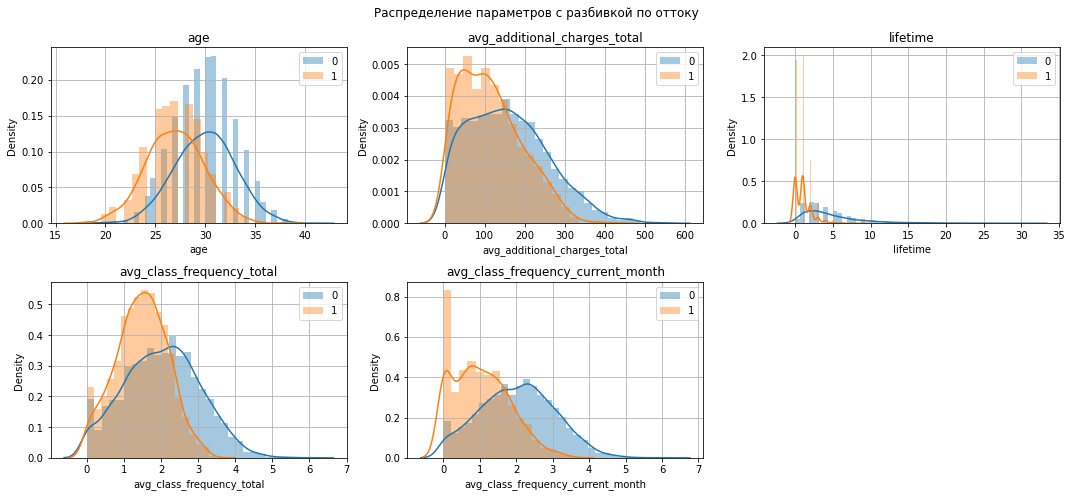

In [9]:
# print(gum.columns.tolist()) # получим список названий столбцов
params = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total','avg_class_frequency_current_month']
col_count, row_count = 3, 2 # зададим число рядов и столбцов в сетке графика
plt.figure(figsize = (15, 7))
for i, param in enumerate(params):
    for churn in gum['churn'].unique():
        current = gum.query('churn == @churn')
        sns.distplot(current[param], label = churn,
                   ax = plt.subplot(row_count, col_count, i + 1) # задаем положение графика в сетке, i+1 порядковый номер графика
                   )
    plt.title(param)
    plt.legend()
    plt.grid(True)
plt.suptitle('Распределение параметров с разбивкой по оттоку')
plt.tight_layout()

**Построим столбцовые графики с накоплением для дискретных переменных**

In [10]:
# создадим таблицу с нужными колонками
gum_bin = gum[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 
               'contract_period', 'churn']]

In [11]:
def feat_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]
    for c in key_cols:
        if c == group_col: continue
        # бинарные колонки
        if len(x_new[c].unique()) < 10:
            report = x_new.reset_index().pivot_table(index = c, columns = group_col, values = 'index', aggfunc = 'count')
            report.plot(kind = 'bar', stacked = True, alpha = 0.5)
        else:
            for cl in x[group_col].unique():
                sns.displot(x_new[x_new[group_col] == c][c],
                           label = '{} = {}'.format(group_col, str(cl)), bins = 10)
                plt.title(c)
                plt.legend()
                plt.show()
        plt.grid(True)
        plt.suptitle('Распределение параметров с разбивкой по оттоку')
        plt.xticks(rotation = 0)

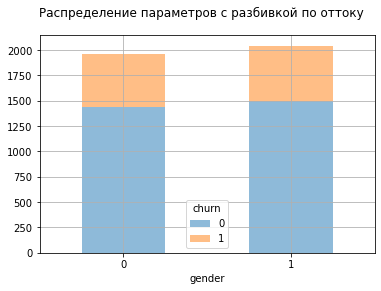

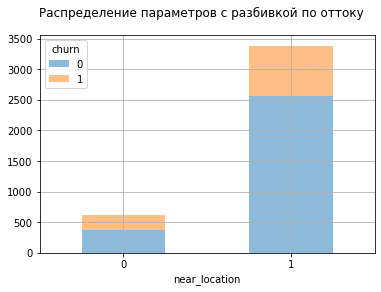

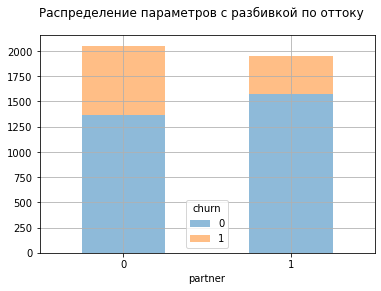

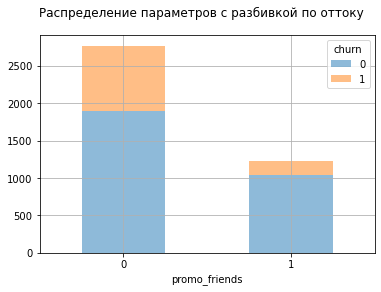

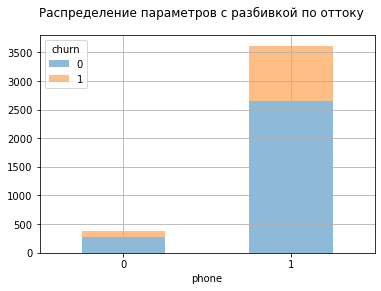

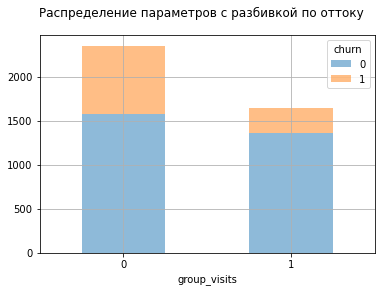

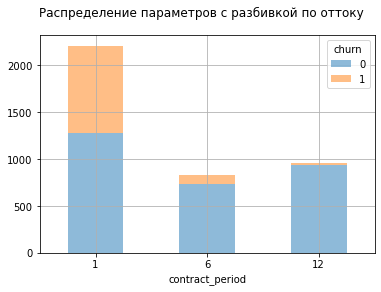

In [12]:
feat_hist(gum_bin, 'churn', gum_bin.columns)

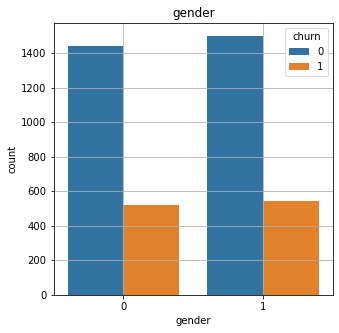

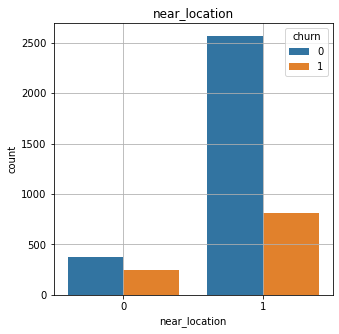

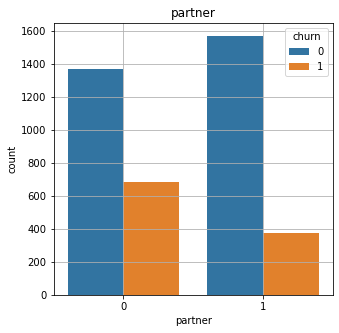

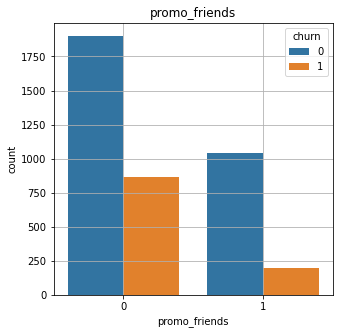

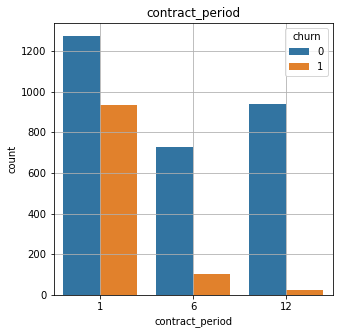

In [13]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gum[column], hue='churn', data=gum)
    plt.title(column)
    plt.grid(True)
    plt.show()

**Построим матрицу корреляций**

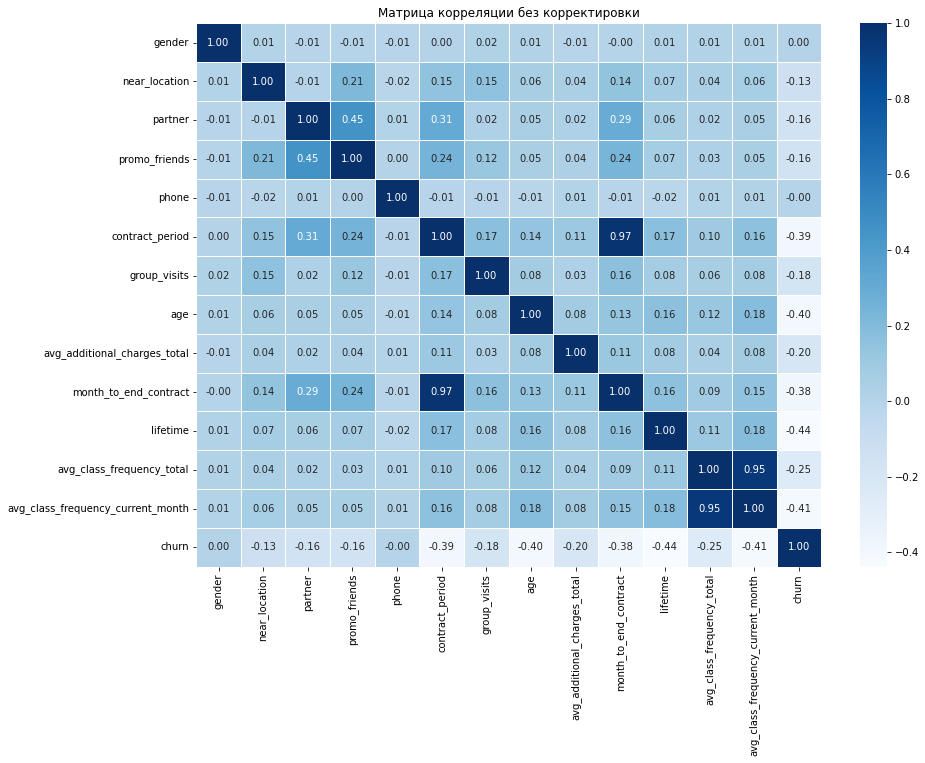

In [14]:
corr = gum.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot = True, fmt = '0.2f', linewidths=.5, cmap='Blues')
#plt.xticks(rotation = 45)
plt.title('Матрица корреляции без корректировки')
plt.show()

**Вывод**  
Выделяются признаки, коррелирующие между собой более чем на 90 %, а именно:
- contract_period-month_to_end_contract;
- avg_class_frequency_total-avg_class_frequency_current_month.  
 ***Необходимо удалить по одному из коррелированных признаков с каждой пары.***

In [15]:
# anime.drop(['anime_id', 'genre', 'members'], axis=1).head()

In [16]:
gum.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1, inplace = True)
# убираем один из пары коррелирующих признаков 

In [17]:
# print(gum.columns.tolist())

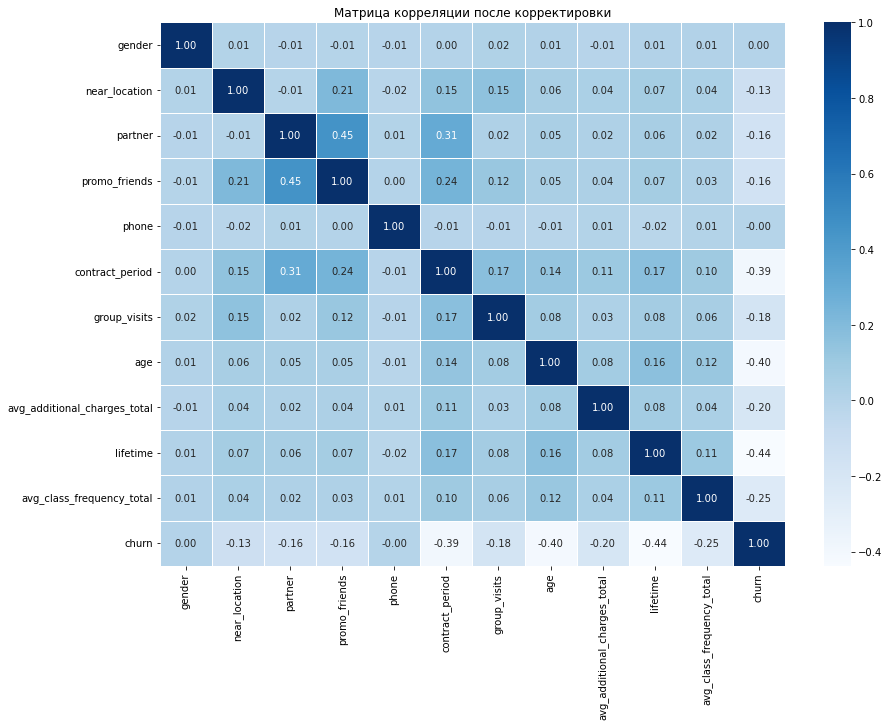

In [18]:
corr = gum.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot = True, fmt = '0.2f', linewidths=.5, cmap='Blues')
#plt.xticks(rotation = 45)
plt.title('Матрица корреляции после корректировки')
plt.show()

**Вывод**  
Уровень оттока снижается в случаях:
- проживания или работы в районе, где находится фитнес-центр
- сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- первоначальная запись в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);




## Построение модели прогнозирования оттока клиентов

### Обучим модель на train-выборке способом логистической регрессии

In [19]:
X = gum.drop('churn', axis = 1)
y = gum['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [20]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [21]:
# print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
# print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
# print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
# print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

In [22]:
def print_metricks(test, pred):
    return print('Accuracy: {:.2f}'.format(accuracy_score(test, pred)),\
                'Precision: {:.2f}'.format(precision_score(test, pred)),\
                'Recall: {:.2f}'.format(recall_score(test, pred)),\
                'F1: {:.2f}'.format(f1_score(test, pred)), sep ='\n')

In [23]:
print_metricks(y_test, predictions)

Accuracy: 0.87
Precision: 0.72
Recall: 0.77
F1: 0.74


### Обучим модель на train-выборке способом случайного леса

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [25]:
print_metricks(y_test, rf_predictions)

Accuracy: 0.89
Precision: 0.79
Recall: 0.76
F1: 0.77


**Вывод:**  
Обучение модели способом случайного леса дает более высокую долю правильных ответов.

### Кластеризация клиентов

In [26]:
df_sс = gum.drop(['churn'], axis=1)
df_columns_list = df_sс.columns
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

In [27]:
linked = linkage(df_sс, method = 'ward')

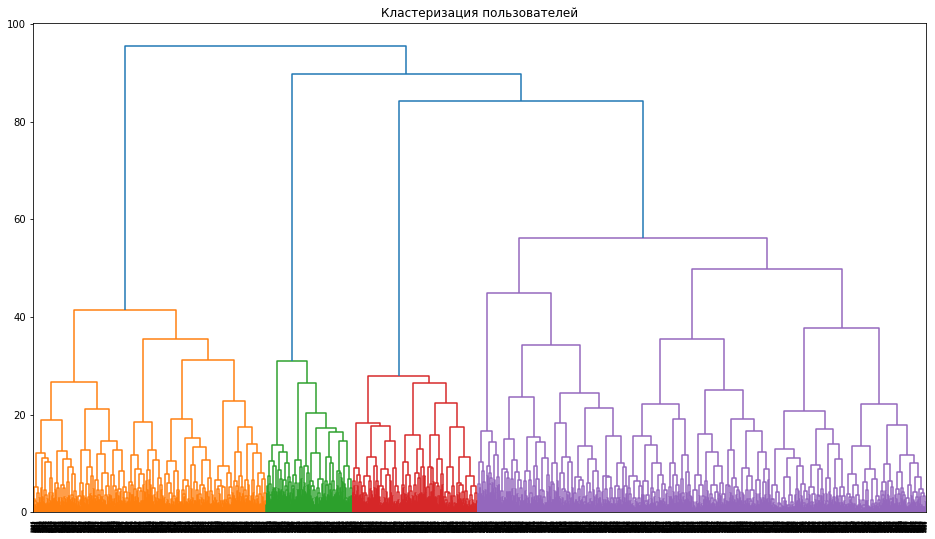

In [28]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

In [29]:
# выделим 5 кластеров
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(df_sс)
gum['cluster'] = labels

In [30]:
# получим количество клиентов по кластерам
cluster_group = gum.cluster.value_counts().reset_index()
cluster_group['%'] = (cluster_group['cluster']*100 / cluster_group['cluster'].sum()).round(1)

cluster_group = cluster_group.rename({'index': 'кластер', 'cluster': 'количество клиентов'},\
                   axis=1, errors='raise')

cluster_group.sort_values(by='%', ascending= False)

,кластер,количество клиентов,%
0,2,1132,28.3
1,1,1050,26.2
2,3,871,21.8
3,0,561,14.0
4,4,386,9.6


In [31]:
display('Средние значения по кластерам', gum.groupby('cluster').mean().T.round(2))

'Средние значения по кластерам'

cluster,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
lifetime,3.06,4.38,3.34,3.76,3.94


**Вывод:**

Кластер с наибольшей склонностью к оттоку 0:  
- пользователей 0 кластера не так много (14 % от общего количества);
- редко ходят на занятия в том числе на групповые ~ 1 раз в неделю;
- пришли без друзей;
- возраст примерно 28 лет.
Необходимо заинтересовать клиента, например персональным тренером со специальными условиями, или программами вроде есть через месяц занятий не будет результата мы вернем вам денньги.

Кластеры с наибольшим удержанием: 1, 3:
- жители района;
- сотрудники компаний-партнеров;
- занимаются с друзьями;
- постоянные клиенты с "длинным" абонементом и платящие за доп.услуги;
- регулярно посещают занятия.

Необходимо поддерживать заинтересованность клиентов, например при покупке годового абонемента давать месяц бесплатно,
предлагать скидки при приближении окончания абонемента.

Промежуточные кластеры 2, 4. Необходимо стабилизировать и снизить показатель оттока :
- не банальные методы. Например, при увелечении количества тренировок в неделю выдавать льготные купоны на сопутствующие услуги (кислородные коктейли, хамам), халяву любят все;
- кластер 2 провален по групповым визитам, необходимо сформировать однополые группы занимающихся и поставить в инструктора противоположный пол, всем нравятся красивые тела противоположного пола (новые тенденции в расчет не берем, я из глубинки, у нас такое не практикуется)).

### Построим графики распределения признаков для кластеров

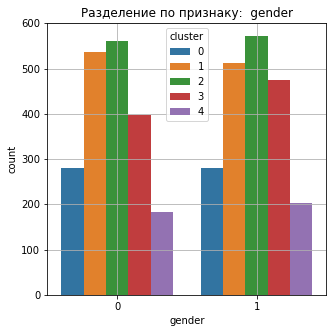

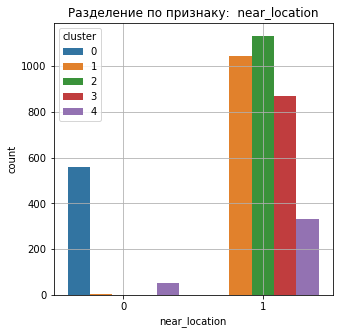

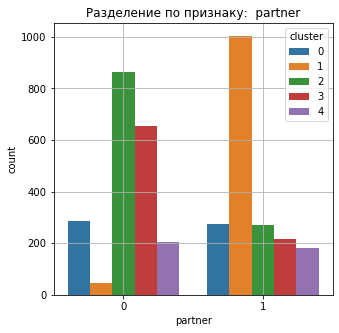

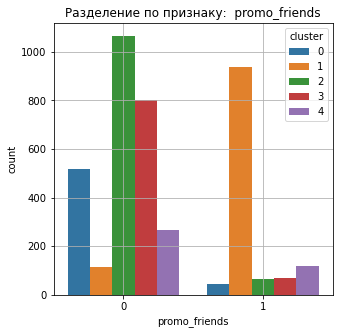

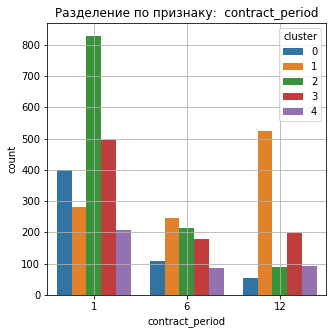

In [32]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gum[column], hue='cluster', data=gum)
    plt.title('Разделение по признаку:  '+ column)
    plt.grid(True)
    plt.show()

In [33]:
# for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
#     plt.figure(figsize=(5, 5))
#     sns.boxplot(x = 'cluster', y = gum[column], data = gum)
#     plt.show()

<Figure size 360x360 with 0 Axes>

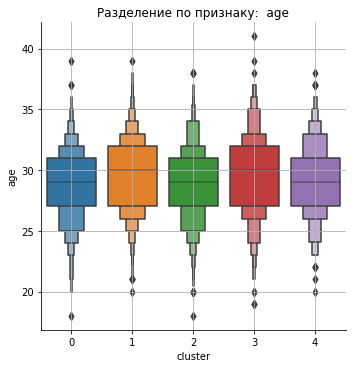

<Figure size 360x360 with 0 Axes>

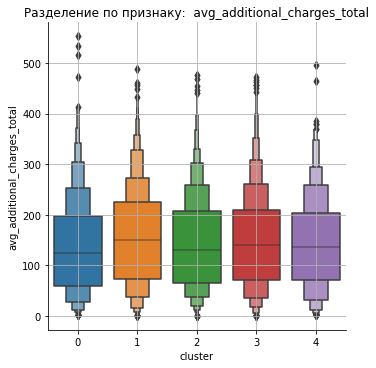

<Figure size 360x360 with 0 Axes>

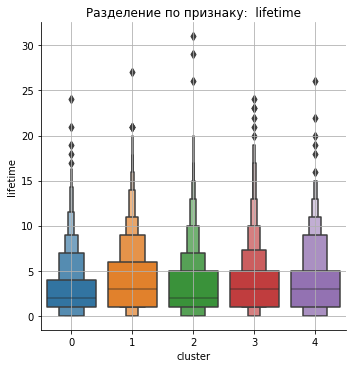

<Figure size 360x360 with 0 Axes>

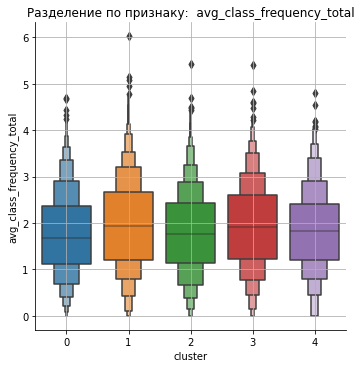

In [34]:
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
    plt.figure(figsize=(5, 5))
    sns.catplot(x = 'cluster', y = column, kind='boxen', data = gum)
    plt.title('Разделение по признаку:  '+ column)
    plt.grid(True)
    plt.show()


***


**Вывод**  
  
  
Для развития необходимо:
- поддерживать и мотивировать лояльные кластеры;
- к каждому сегменту уходящих искать индивидуальные предложения;
- стараться предупредить отток;
- развивать направление привлечения новых клиентов по акции "приведи друга";
- расширять рекламу клуба в районе его расположения;
- повышать вовлеченность на групповых занятиях;
- расширять программы привлечения сотрудников компаний-партнеров и списка самих партнеров.

***